In [118]:
import pandas as pd
import numpy as np
import glob
import os

In [119]:
Test_root = './cats_dogs/test/'
Train_root = ('./cats_dogs/train')
X_path = glob.glob(os.path.join(Test_root + "/dogs/*.wav"))
X_path = X_path + glob.glob(os.path.join(Test_root + "/cats/*.wav"))
X_path = X_path + glob.glob(os.path.join(Train_root + "/dog/*.wav"))
X_path = X_path + glob.glob(os.path.join(Train_root + "/cat/*.wav"))
print(len(X_path))

277


In [141]:
import ntpath
y = np.empty((0, 1, ))
for f in X_path:
    if 'cat' in ntpath.basename(f):
        resp = np.array([0])
        #print(resp.shape)
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))
    elif 'dog' in ntpath.basename(f):
        resp = np.array([1])
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.25, random_state=42)
#ipd.Audio(X_test[1], rate=wav_rate)

In [122]:
import librosa
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [librosa.load(f)[0] for f in wav_files]

In [147]:
#print(*y_train, sep="\n")

In [124]:
wav_rate = librosa.load(X_train[0])[1]
#print(X_train)
X_train = librosa_read_wav_files(X_train)
#print(X_train)
X_test = librosa_read_wav_files(X_test)
#print(X_test)

In [ ]:
#print(*X_train, sep='\n')

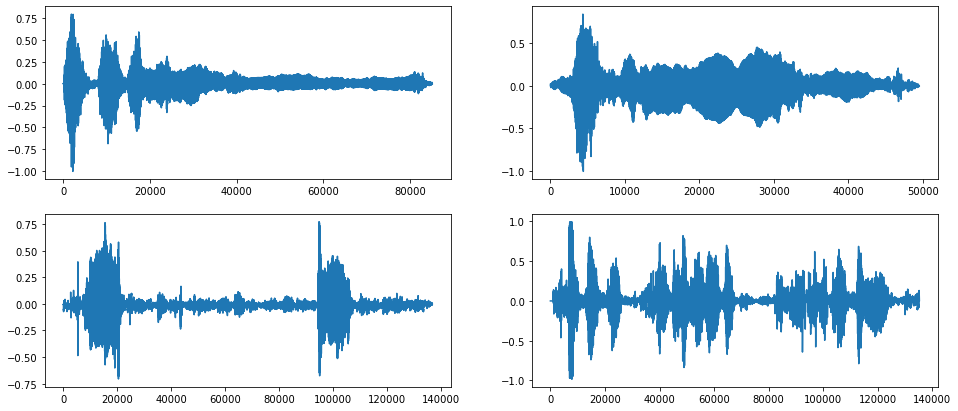

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(16,7))
axs[0][0].plot(X_train[0])
axs[0][1].plot(X_train[1])
axs[1][0].plot(X_train[2])
axs[1][1].plot(X_train[3])
plt.show()

In [77]:
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, ))
    if not isinstance (audio_samples, list):
        audio_samples = [audio_samples]
    
    for sample in audio_samples:
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean()
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T, axis=0)
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

In [78]:
X_train_features = extract_features(X_train, wav_rate)
X_test_features = extract_features(X_test, wav_rate)

In [79]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

In [80]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [81]:
model = models.Sequential()

model.add(layers.Dense(100, activation='relu', input_shape= (41,)))
model.add(Dropout(0.1))

model.add(layers.Dense(50, activation='relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               4200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
Total para

In [82]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)

callbacks = [checkpoint]

model.compile(optimizer='adam',
             loss=losses.categorical_crossentropy,
             metrics=['accuracy'])

In [83]:
history = model.fit(
    X_train_features,
    train_labels,
    validation_data=(X_test_features, test_labels),
    epochs=200,
    verbose=1,
    callbacks=callbacks,
)

Train on 207 samples, validate on 70 samples
Epoch 1/200
207/207 [==============================] - 0s - loss: 5.8828 - acc: 0.5652 - val_loss: 5.8937 - val_acc: 0.6000
Epoch 2/200
207/207 [==============================] - 0s - loss: 6.4555 - acc: 0.5459 - val_loss: 6.3702 - val_acc: 0.5857
Epoch 3/200
207/207 [==============================] - 0s - loss: 4.7720 - acc: 0.6425 - val_loss: 6.5784 - val_acc: 0.5857
Epoch 4/200
207/207 [==============================] - 0s - loss: 5.7726 - acc: 0.5942 - val_loss: 6.0840 - val_acc: 0.5857
Epoch 5/200
207/207 [==============================] - 0s - loss: 5.2176 - acc: 0.6232 - val_loss: 3.1409 - val_acc: 0.7143
Epoch 6/200
207/207 [==============================] - 0s - loss: 4.2836 - acc: 0.7005 - val_loss: 2.0593 - val_acc: 0.8429
Epoch 7/200
207/207 [==============================] - 0s - loss: 4.4828 - acc: 0.6425 - val_loss: 1.7284 - val_acc: 0.8286
Epoch 8/200
207/207 [==============================] - 0s - loss: 3.5502 - acc: 0.7101 

207/207 [==============================] - 0s - loss: 0.7957 - acc: 0.8599 - val_loss: 0.9978 - val_acc: 0.8857
Epoch 35/200
207/207 [==============================] - 0s - loss: 1.0538 - acc: 0.8647 - val_loss: 0.9613 - val_acc: 0.8857
Epoch 36/200
207/207 [==============================] - 0s - loss: 1.0981 - acc: 0.8357 - val_loss: 0.8668 - val_acc: 0.9000
Epoch 37/200
207/207 [==============================] - 0s - loss: 0.7398 - acc: 0.8696 - val_loss: 0.7961 - val_acc: 0.8857
Epoch 38/200
207/207 [==============================] - 0s - loss: 0.7590 - acc: 0.8551 - val_loss: 0.7097 - val_acc: 0.9000
Epoch 39/200
207/207 [==============================] - 0s - loss: 0.7874 - acc: 0.8841 - val_loss: 0.7170 - val_acc: 0.8857
Epoch 40/200
207/207 [==============================] - 0s - loss: 0.8450 - acc: 0.8116 - val_loss: 0.7256 - val_acc: 0.8857
Epoch 41/200
207/207 [==============================] - 0s - loss: 0.7023 - acc: 0.8551 - val_loss: 0.7270 - val_acc: 0.8714
Epoch 42/200


207/207 [==============================] - 0s - loss: 0.3362 - acc: 0.8937 - val_loss: 0.6968 - val_acc: 0.8714
Epoch 69/200
207/207 [==============================] - 0s - loss: 0.2985 - acc: 0.9130 - val_loss: 0.6983 - val_acc: 0.8714
Epoch 70/200
207/207 [==============================] - 0s - loss: 0.3865 - acc: 0.8792 - val_loss: 0.6895 - val_acc: 0.8714
Epoch 71/200
207/207 [==============================] - 0s - loss: 0.4453 - acc: 0.8841 - val_loss: 0.6851 - val_acc: 0.8571
Epoch 72/200
207/207 [==============================] - 0s - loss: 0.3738 - acc: 0.8841 - val_loss: 0.6254 - val_acc: 0.8571
Epoch 73/200
207/207 [==============================] - 0s - loss: 0.3457 - acc: 0.8647 - val_loss: 0.5738 - val_acc: 0.8571
Epoch 74/200
207/207 [==============================] - 0s - loss: 0.3134 - acc: 0.8841 - val_loss: 0.5498 - val_acc: 0.8714
Epoch 75/200
207/207 [==============================] - 0s - loss: 0.3570 - acc: 0.8502 - val_loss: 0.5457 - val_acc: 0.8714
Epoch 76/200


207/207 [==============================] - 0s - loss: 0.2162 - acc: 0.8792 - val_loss: 0.5612 - val_acc: 0.8857
Epoch 103/200
207/207 [==============================] - 0s - loss: 0.2508 - acc: 0.9034 - val_loss: 0.5751 - val_acc: 0.8857
Epoch 104/200
207/207 [==============================] - 0s - loss: 0.2418 - acc: 0.9372 - val_loss: 0.5822 - val_acc: 0.8857
Epoch 105/200
207/207 [==============================] - 0s - loss: 0.3627 - acc: 0.8889 - val_loss: 0.5605 - val_acc: 0.8714
Epoch 106/200
207/207 [==============================] - 0s - loss: 0.3170 - acc: 0.9034 - val_loss: 0.5538 - val_acc: 0.8714
Epoch 107/200
207/207 [==============================] - 0s - loss: 0.3314 - acc: 0.8841 - val_loss: 0.5496 - val_acc: 0.8857
Epoch 108/200
207/207 [==============================] - 0s - loss: 0.2364 - acc: 0.8986 - val_loss: 0.5714 - val_acc: 0.8857
Epoch 109/200
207/207 [==============================] - 0s - loss: 0.2603 - acc: 0.8986 - val_loss: 0.6053 - val_acc: 0.8714
Epoch 

207/207 [==============================] - 0s - loss: 0.1726 - acc: 0.9179 - val_loss: 0.6685 - val_acc: 0.8857
Epoch 137/200
207/207 [==============================] - 0s - loss: 0.1832 - acc: 0.9179 - val_loss: 0.7007 - val_acc: 0.8857
Epoch 138/200
207/207 [==============================] - 0s - loss: 0.1687 - acc: 0.9082 - val_loss: 0.6963 - val_acc: 0.9000
Epoch 139/200
207/207 [==============================] - 0s - loss: 0.1650 - acc: 0.9324 - val_loss: 0.6966 - val_acc: 0.9000
Epoch 140/200
207/207 [==============================] - 0s - loss: 0.1919 - acc: 0.9275 - val_loss: 0.6724 - val_acc: 0.9000
Epoch 141/200
207/207 [==============================] - 0s - loss: 0.1650 - acc: 0.9179 - val_loss: 0.6858 - val_acc: 0.9000
Epoch 142/200
207/207 [==============================] - 0s - loss: 0.2494 - acc: 0.9227 - val_loss: 0.6906 - val_acc: 0.8857
Epoch 143/200
207/207 [==============================] - 0s - loss: 0.1759 - acc: 0.9130 - val_loss: 0.7121 - val_acc: 0.8857
Epoch 

207/207 [==============================] - 0s - loss: 0.1543 - acc: 0.9324 - val_loss: 0.7707 - val_acc: 0.9000
Epoch 171/200
207/207 [==============================] - 0s - loss: 0.1402 - acc: 0.9420 - val_loss: 0.7868 - val_acc: 0.9000
Epoch 172/200
207/207 [==============================] - 0s - loss: 0.1929 - acc: 0.9372 - val_loss: 0.7766 - val_acc: 0.9000
Epoch 173/200
207/207 [==============================] - 0s - loss: 0.1597 - acc: 0.9275 - val_loss: 0.7843 - val_acc: 0.9000
Epoch 174/200
207/207 [==============================] - 0s - loss: 0.2652 - acc: 0.9324 - val_loss: 0.7953 - val_acc: 0.9000
Epoch 175/200
207/207 [==============================] - 0s - loss: 0.1402 - acc: 0.9275 - val_loss: 0.8085 - val_acc: 0.9000
Epoch 176/200
207/207 [==============================] - 0s - loss: 0.2304 - acc: 0.9227 - val_loss: 0.8321 - val_acc: 0.9000
Epoch 177/200
207/207 [==============================] - 0s - loss: 0.1403 - acc: 0.9420 - val_loss: 0.8702 - val_acc: 0.8857
Epoch 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<function matplotlib.pyplot.show(close=None, block=None)>

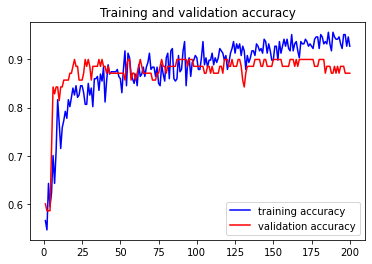

In [84]:
print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label="training accuracy")
plt.plot(epochs, val_acc, 'r', label="validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.show

In [56]:
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

Cat: 0.6970049738883972 Dog: 0.30299505591392517
This is a cat meowing


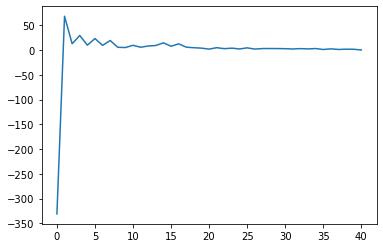

In [152]:
import IPython.display as ipd
nr_to_predict=5
pred=model.predict(X_test_features[4].reshape(1, 41))

print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

if (y_test[4]==0):
    print("This is a cat meowing")
else:
    print("This is a dog barking")
    
plt.plot(X_test_features[4])
ipd.Audio(X_test[4], rate=wav_rate)

In [168]:
path = './cat.wav'
#print(path)
test = librosa_read_wav_files(path)
print(test)
test_features = extract_features(test, wav_rate)
print(test_features)

[array([-0.00375907, -0.00616728, -0.00355973, ...,  0.01311207,
        0.0093008 ,  0.        ], dtype=float32)]
[[-1.16072411e+02  2.05853409e+02 -2.94189987e+01  4.32716293e+01
  -1.04712820e+01  1.94620743e+01 -8.26787567e+00  4.17468262e+00
   4.39102507e+00  3.62400234e-01  2.88467169e+00 -4.45590973e+00
  -1.38143539e+00 -6.26898909e+00 -1.86785817e+00 -1.40624628e+01
  -1.94220328e+00 -1.34984165e-01  6.97969055e+00  4.75642776e+00
  -4.82212126e-01 -9.51322258e-01 -4.31753778e+00 -1.14266145e+00
  -5.62350702e+00  1.23712921e+00 -4.27678251e+00 -7.84903288e-01
  -3.33976507e+00 -2.03341794e+00  9.72864330e-01 -3.48064160e+00
  -1.91316772e+00 -4.09837437e+00  6.42679632e-01 -4.63865614e+00
  -2.09379172e+00 -3.25537467e+00 -4.46267414e+00 -9.41327751e-01
   5.14075238e-02]]


Cat: 0.9999938011169434 Dog: 6.166968887555413e-06


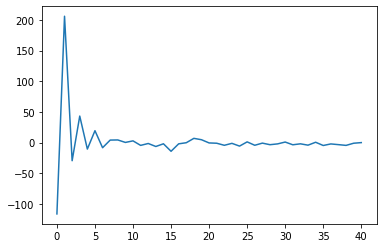

In [169]:
pred = model.predict(test_features[0].reshape(1,41))

print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))

plt.plot(test_features[0])
ipd.Audio(test, rate=wav_rate)